In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Iteration 4').getOrCreate()

import numpy as np
import pandas as pd

# If you're getting an error with numpy, please type 'sudo pip install numpy --user' into the EC2 console.
from pyspark.ml.regression import LinearRegression

# 2. DATA UNDERSTANDING

In [2]:
# Load the Data 
bank = spark.read.csv("bank.csv", inferSchema=True, header=True, nullValue='unknown')

In [3]:
# Check the number of rows and columns
bank.count(), len(bank.columns)

(41188, 21)

# Data Exploration

In [4]:
# Check object type
print(type(bank))

# Cek column types
print(bank.printSchema())

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- takers: integer (nullable = true)

None


# For the EDA Visualization -> See the Tableau Files

In [5]:
# Descriptive Statistics of the numerical columns
bank.describe().toPandas()

,summary,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,takers
0,count,41188,40858,41108,39457,32591,40198,40198,41188,41188,...,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
1,mean,40.02406040594348,None,None,None,None,None,None,None,None,...,2.567592502670681,962.4754540157328,0.17296299893172767,None,-0.6517393316357063,85393.73800676703,-40.50260027191399,3179.731503495394,1152.9059172064758,0.11265417111780131
2,stddev,10.421249980934045,None,None,None,None,None,None,None,None,...,2.770013542902322,186.91090734474153,0.49490107983929055,None,1.0248699440001923,26496.779264029818,4.628197856174574,2087.2625209512007,1946.0827256394978,0.3161734269429656
3,min,17,admin.,divorced,basic.4y,no,no,no,cellular,apr,...,1,0,0,failure,-3.4,3.876388889,-50.8,0.004861111,206.7958333,0
4,max,98,unemployed,single,university.degree,yes,yes,yes,telephone,sep,...,56,999,7,success,0.044444444,94767.0,-26.9,5045.0,5191.0,1


In [6]:
# Check Missing Values
from pyspark.sql.functions import *
import pyspark.sql.functions as f

bank_agg = bank.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in bank.columns])
from functools import reduce
bank_agg_col = reduce(
    lambda a, b: a.union(b),
    (
        bank_agg.select(f.lit(c).alias("Column_Name"), f.col(c).alias("Count_Missing")) 
        for c in bank_agg.columns
    )
)

bank_agg_col = bank_agg_col.withColumn('Percent_Missing (%)', expr('Count_Missing/41188*100'))
bank_agg_col = bank_agg_col.select(['Column_Name', 'Count_Missing', 
                                    round('Percent_Missing (%)', 3).alias("Percent_Missing (%)")])
bank_agg_col.show()

+--------------+-------------+-------------------+
|   Column_Name|Count_Missing|Percent_Missing (%)|
+--------------+-------------+-------------------+
|           age|            0|                0.0|
|           job|          330|              0.801|
|       marital|           80|              0.194|
|     education|         1731|              4.203|
|       default|         8597|             20.873|
|       housing|          990|              2.404|
|          loan|          990|              2.404|
|       contact|            0|                0.0|
|         month|            0|                0.0|
|   day_of_week|            0|                0.0|
|      duration|            0|                0.0|
|      campaign|            0|                0.0|
|         pdays|            0|                0.0|
|      previous|            0|                0.0|
|      poutcome|            0|                0.0|
|  emp_var_rate|            0|                0.0|
|cons_price_idx|            0| 

In [7]:
# View the top 5 observation in a Pandas data type
bank.limit(5).toPandas()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,takers
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,0.042361,93994.0,-36.4,4857.0,5191.0,0
1,57,services,married,high.school,None,no,no,telephone,may,mon,...,1,999,0,nonexistent,0.042361,93994.0,-36.4,4857.0,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,0.042361,93994.0,-36.4,4857.0,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,0.042361,93994.0,-36.4,4857.0,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,0.042361,93994.0,-36.4,4857.0,5191.0,0


In [8]:
# Check Outliers
bounds = {
    c: dict(
        zip(["q1", "q3"], bank.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in ['age','duration','campaign','pdays','previous','emp_var_rate',
              'cons_price_idx','cons_conf_idx','euribor3m','nr_employed']
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)

bank_outliers = bank.select(
    "*",
    *[
        f.when(
            f.col(c).between(bounds[c]['lower'], bounds[c]['upper']),
            0
        ).otherwise(1).alias(c+"_out") 
        for c in ['age','duration','campaign','pdays','previous','emp_var_rate',
                  'cons_price_idx','cons_conf_idx','euribor3m','nr_employed']
    ]
)

bank_outliers.limit(5).toPandas()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,age_out,duration_out,campaign_out,pdays_out,previous_out,emp_var_rate_out,cons_price_idx_out,cons_conf_idx_out,euribor3m_out,nr_employed_out
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,1
1,57,services,married,high.school,None,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,1


In [9]:
bank_agg_2 = bank_outliers.agg(*[f.sum(c).alias(c) for c in ['age_out','duration_out','campaign_out',
                                                             'pdays_out','previous_out','emp_var_rate_out',
                                                             'cons_price_idx_out','cons_conf_idx_out',
                                                             'euribor3m_out','nr_employed_out']])
from functools import reduce
bank_outliers_col = reduce(
    lambda a, b: a.union(b),
    (
        bank_agg_2.select(f.lit(c).alias("Column_Name"), f.col(c).alias("Count_Outliers")) 
        for c in ['age_out','duration_out','campaign_out','pdays_out','previous_out','emp_var_rate_out',
                  'cons_price_idx_out','cons_conf_idx_out','euribor3m_out','nr_employed_out']
    )
)

bank_outliers_col = bank_outliers_col.withColumn('Percent_Outliers (%)', expr('Count_Outliers/41188*100'))
bank_outliers_col = bank_outliers_col.select(['Column_Name', 'Count_Outliers', 
                                    round('Percent_Outliers (%)', 3).alias("Percent_Outliers (%)")])
bank_outliers_col.show()

+------------------+--------------+--------------------+
|       Column_Name|Count_Outliers|Percent_Outliers (%)|
+------------------+--------------+--------------------+
|           age_out|           469|               1.139|
|      duration_out|          2963|               7.194|
|      campaign_out|          2406|               5.842|
|         pdays_out|          1515|               3.678|
|      previous_out|          5625|              13.657|
|  emp_var_rate_out|             0|                 0.0|
|cons_price_idx_out|          3616|               8.779|
| cons_conf_idx_out|           447|               1.085|
|     euribor3m_out|             0|                 0.0|
|   nr_employed_out|          7763|              18.848|
+------------------+--------------+--------------------+



# 3. Data Preparation

In [2]:
# Load the Data 
bank = spark.read.csv("bank.csv", inferSchema=True, header=True)

# 3.1	Select the data 

In [3]:
bank = bank.filter(bank.pdays==999)

# Check the number of rows and columns
bank.count(), len(bank.columns)

(39673, 21)

In [4]:
# Drop Columns
bank = bank.drop("pdays", "duration")

# Check the number of rows and columns
bank.count(), len(bank.columns)

(39673, 19)

# 3.2 Clean the data 

In [5]:
# Remove Missing Values
bank = bank.filter(bank.marital!='unknown')
bank = bank.filter(bank.education!='unknown')
bank = bank.filter(bank.housing!='unknown')
bank = bank.filter(bank.loan!='unknown')

In [6]:
# Check the number of rows and columns
bank.count(), len(bank.columns)

(37058, 19)

In [7]:
# Check Missing Values
from pyspark.sql.functions import *
import pyspark.sql.functions as f

bank_agg = bank.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in bank.columns])
from functools import reduce
bank_agg_col = reduce(
    lambda a, b: a.union(b),
    (
        bank_agg.select(f.lit(c).alias("Column_Name"), f.col(c).alias("Count_Missing")) 
        for c in bank_agg.columns
    )
)

bank_agg_col = bank_agg_col.withColumn('Percent_Missing (%)', expr('Count_Missing/41188*100'))
bank_agg_col = bank_agg_col.select(['Column_Name', 'Count_Missing', 
                                    round('Percent_Missing (%)', 3).alias("Percent_Missing (%)")])
bank_agg_col.show()

+--------------+-------------+-------------------+
|   Column_Name|Count_Missing|Percent_Missing (%)|
+--------------+-------------+-------------------+
|           age|            0|                0.0|
|           job|            0|                0.0|
|       marital|            0|                0.0|
|     education|            0|                0.0|
|       default|            0|                0.0|
|       housing|            0|                0.0|
|          loan|            0|                0.0|
|       contact|            0|                0.0|
|         month|            0|                0.0|
|   day_of_week|            0|                0.0|
|      campaign|            0|                0.0|
|      previous|            0|                0.0|
|      poutcome|            0|                0.0|
|  emp_var_rate|            0|                0.0|
|cons_price_idx|            0|                0.0|
| cons_conf_idx|            0|                0.0|
|     euribor3m|            0| 

# 3.3 Construct the data 

In [8]:
# age_group
bank = bank.withColumn('age_group', 
                       f.when(f.col('age') <= 31, "<=31").
                       when(f.col('age').between(32,37), "32-37").
                       when(f.col('age').between(38,45), "38-45").
                       otherwise(">=46"))

# education_regrouping
bank = bank.withColumn('education_regrouping', 
                       f.when((f.col('education')=='basic.4y') | (f.col('education') == 'basic.6y') | 
                              (f.col('education')=='basic.9y') | (f.col('education')=='illiterate'), 'Low').
                       when(f.col('education')=='high.school', 'Middle').
                       otherwise('High'))

# season
bank = bank.withColumn('quarter', 
                       f.when((f.col('month')=='jan') | (f.col('month') == 'feb') | (f.col('month')=='mar'), 'Q1').
                       when((f.col('month')=='apr') | (f.col('month') == 'may') | (f.col('month')=='jun'), 'Q2').
                       when((f.col('month')=='jul') | (f.col('month') == 'aug') | (f.col('month')=='sep'), 'Q3').
                       otherwise('Q4'))

bank.limit(5).toPandas()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,takers,age_group,education_regrouping,quarter
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,nonexistent,0.042361,93994.0,-36.4,4857.0,5191.0,0,>=46,Low,Q2
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,nonexistent,0.042361,93994.0,-36.4,4857.0,5191.0,0,>=46,Middle,Q2
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,nonexistent,0.042361,93994.0,-36.4,4857.0,5191.0,0,32-37,Middle,Q2
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,nonexistent,0.042361,93994.0,-36.4,4857.0,5191.0,0,38-45,Low,Q2
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,nonexistent,0.042361,93994.0,-36.4,4857.0,5191.0,0,>=46,Middle,Q2


In [9]:
bank.groupBy("age_group").agg({'age_group':'count'}).show()
bank.groupBy("education_regrouping").agg({'education_regrouping':'count'}).show()
bank.groupBy("quarter").agg({'quarter':'count'}).show()

+---------+----------------+
|age_group|count(age_group)|
+---------+----------------+
|    38-45|            8721|
|    32-37|            9648|
|     >=46|           10323|
|     <=31|            8366|
+---------+----------------+

+--------------------+---------------------------+
|education_regrouping|count(education_regrouping)|
+--------------------+---------------------------+
|                High|                      16217|
|                 Low|                      11884|
|              Middle|                       8957|
+--------------------+---------------------------+

+-------+--------------+
|quarter|count(quarter)|
+-------+--------------+
|     Q2|         19721|
|     Q1|           426|
|     Q3|         12547|
|     Q4|          4364|
+-------+--------------+



# 3.4 Integrate various data sources 

In [10]:
bank_jan_jun = bank.filter(col('month').isin(['jan','feb', 'mar', 'apr','may','jun']))
bank_jul_dec = bank.filter(col('month').isin(['jul','aug','sep','oct','nov','dec']))

In [11]:
# Check the number of rows and columns
print(bank_jan_jun.count(), len(bank_jan_jun.columns))
print(bank_jul_dec.count(), len(bank_jul_dec.columns))

20147 22
16911 22


In [12]:
# Integrate various data sources 
bank = bank_jan_jun.union(bank_jul_dec)

# Check the number of rows and columns
bank.count(), len(bank.columns)

(37058, 22)

# 3.5 Format the data as required

In [13]:
# Format the data as required

# Check the data type
print(bank.printSchema())

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- takers: integer (nullable = true)
 |-- age_group: string (nullable = false)
 |-- education_regrouping: string (nullable = false)
 |-- quarter: string (nullable = false)

None


In [164]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

# Get list of categorical columns except the target variable
categorical_cols = [c.name for c in bank.schema.fields if c.dataType.simpleString() == "string"]

# Get list of non-categorical columns and remove our target variable from the list
non_categorical_cols = [c.name for c in bank.schema.fields if c.dataType.simpleString() != "string"]
non_categorical_cols.remove("takers")

# Build StringIndexer stages
string_indexer = [StringIndexer(inputCol = c, outputCol = c + "INT") for c in categorical_cols]

# Input the StringIndexer stages to build the pipeline model
pipe = Pipeline(stages = string_indexer)

# Apply the pipeline model to the dataset
indexed_data = pipe.fit(bank).transform(bank)

# Concatenate all the columns
bank_reformatted = indexed_data.select([c + "INT" for c in categorical_cols] + non_categorical_cols + ["takers"])

# Rearrange the columns
bank_reformatted = bank_reformatted.select('age','age_groupINT','jobINT','maritalINT','educationINT',
                                           'education_regroupingINT','defaultINT','housingINT','loanINT',
                                           'contactINT','monthINT','quarterINT','day_of_weekINT','campaign',
                                           'previous','poutcomeINT','emp_var_rate','cons_price_idx',
                                           'cons_conf_idx','euribor3m','nr_employed','takers')

In [165]:
# Check the columnn type
print(bank_reformatted.printSchema())

root
 |-- age: integer (nullable = true)
 |-- age_groupINT: double (nullable = true)
 |-- jobINT: double (nullable = true)
 |-- maritalINT: double (nullable = true)
 |-- educationINT: double (nullable = true)
 |-- education_regroupingINT: double (nullable = true)
 |-- defaultINT: double (nullable = true)
 |-- housingINT: double (nullable = true)
 |-- loanINT: double (nullable = true)
 |-- contactINT: double (nullable = true)
 |-- monthINT: double (nullable = true)
 |-- quarterINT: double (nullable = true)
 |-- day_of_weekINT: double (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcomeINT: double (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- takers: integer (nullable = true)

None


In [167]:
bank_reformatted.limit(5).toPandas()

,age,age_groupINT,jobINT,maritalINT,educationINT,education_regroupingINT,defaultINT,housingINT,loanINT,contactINT,...,day_of_weekINT,campaign,previous,poutcomeINT,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,takers
0,56,0.0,8.0,0.0,4.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1,0,0.0,0.042361,93994.0,-36.4,4857.0,5191.0,0
1,57,0.0,3.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,...,1.0,1,0,0.0,0.042361,93994.0,-36.4,4857.0,5191.0,0
2,37,1.0,3.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,...,1.0,1,0,0.0,0.042361,93994.0,-36.4,4857.0,5191.0,0
3,40,2.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1,0,0.0,0.042361,93994.0,-36.4,4857.0,5191.0,0
4,56,0.0,3.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,...,1.0,1,0,0.0,0.042361,93994.0,-36.4,4857.0,5191.0,0


# 4. DATA TRANSFORMATION

# 4.1 Reduce the data 

In [168]:
# Feature Selection 

# Using Business Logic
bank_reformatted = bank_reformatted.drop("age", "educationINT","monthINT")

# Check the number of rows and columns
bank_reformatted.count(), len(bank_reformatted.columns)

(37058, 19)

In [169]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors

assembler = VectorAssembler(inputCols= [c for c in bank_reformatted.columns if c not in {'takers'}], 
                            outputCol="features")

rf = RandomForestClassifier(labelCol="takers", featuresCol="features", seed = 1234,
                            numTrees=10, cacheNodeIds = True, subsamplingRate = 0.7)

pipe = Pipeline(stages = [assembler, rf])

mod = pipe.fit(bank_reformatted)

bank_reformatted_2 = mod.transform(bank_reformatted).select(["features", "takers"])

In [170]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [171]:
feature_selection = ExtractFeatureImp(mod.stages[-1].featureImportances, bank_reformatted_2, "features")
feature_selection.drop(["idx", "vals"], axis=1)

,name,score
17,nr_employed,0.262272
13,emp_var_rate,0.188672
16,euribor3m,0.181942
15,cons_conf_idx,0.125262
8,quarterINT,0.081126
14,cons_price_idx,0.064445
9,day_of_weekINT,0.017682
7,contactINT,0.017502
1,jobINT,0.012899
11,campaign,0.010186


In [172]:
# Remove Variable marital, loan, and housing based on the random forest feature selection approach
bank_reformatted = bank_reformatted.drop("housingINT","education_regroupingINT","loanINT")

# Check the number of rows and columns
bank_reformatted.count(), len(bank_reformatted.columns)

(37058, 16)

# 4.2 Project the data

In [173]:
# Undersampling the majority class

# Split data set into two (takers & non-takers)
bank_reformatted_takers = bank_reformatted.filter("takers = 1")

bank_reformatted_non_takers = bank_reformatted.filter("takers = 0")

# Calculate the ratio for undersampling the majority class
sample_ratio = bank_reformatted_takers.count()/bank_reformatted_non_takers.count()

# Randomly sample from majority class with specified ratio
bank_undersampling = bank_reformatted_takers.unionAll(bank_reformatted_non_takers.
                                                      sample(False, sample_ratio, seed=1234))

In [174]:
# Check the number of rows and columns
bank_undersampling.count(), len(bank_undersampling.columns)

(6791, 16)

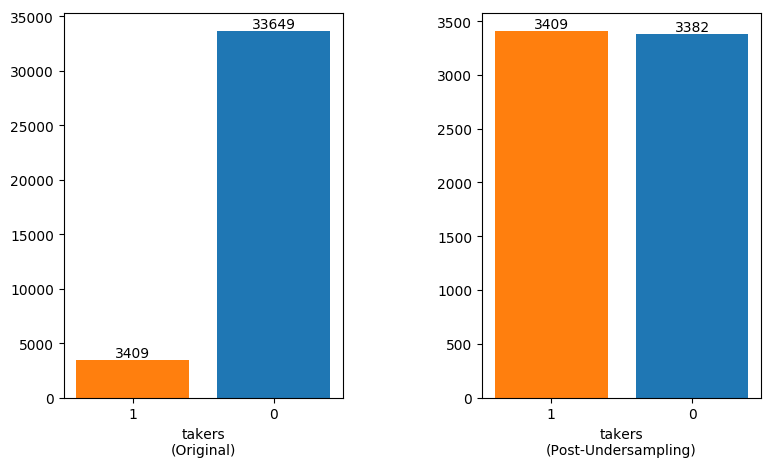

In [175]:
# Check the takers proportion 
import matplotlib.pyplot as plt

original = bank_reformatted.groupBy("takers").count().toPandas()
after_undersampling = bank_undersampling.groupBy("takers").count().toPandas()


fig, ax = plt.subplots(ncols = 2, figsize=(9, 5))
plt.subplots_adjust(wspace = 0.5)

ypos = np.arange(len(original["takers"]))
bar_colours = ["#ff7f0e", "#1f77b4"]

# Bar plot for original data set proportion
ax[0].bar(ypos, original["count"], tick_label = original["takers"], color = bar_colours)
ax[0].set(xlabel = "takers\n(Original)")
# Annotation config
for p in ax[0].patches:
    ax[0].text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        "%d" % int(p.get_height()),
        fontsize = 10,
        ha = "center",
        va = "bottom"
    )

# Bar plot for undersampled data set proportion
ax[1].bar(ypos, after_undersampling["count"], tick_label = after_undersampling["takers"], color = bar_colours)
ax[1].set(xlabel = "takers\n(Post-Undersampling)")
# Annotation config
for p in ax[1].patches:
    ax[1].text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        "%d" % int(p.get_height()),
        fontsize = 10,
        ha = "center",
        va = "bottom"
    )

plt.show()

# Final Feature Matrix

In [176]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

# Get list of categorical columns except the target variable
categorical_cols = [c for c in bank_undersampling.columns if 'INT' in c]

# Get list of non-categorical columns and remove our target variable from the list
non_categorical_cols = [c for c in bank_undersampling.columns if 'INT' not in c]
non_categorical_cols.remove("takers")

# Get list of target variable 
target_cols = bank_undersampling.select("takers")

# Build OneHotEncoder stages
one_hot_encoding = [OneHotEncoder(inputCol = c, outputCol = c + "_Dummy") for c in categorical_cols]

# Build VectorEncoder stage
vector_assembler = VectorAssembler(inputCols = [c + "_Dummy" for c in categorical_cols] + non_categorical_cols,
                                   outputCol = "features")

# Combine all stages to build the pipeline model
pipe = Pipeline(stages = one_hot_encoding + [vector_assembler])

# Fit and transform our undersampled data - this is the final version of our data
bank_final_data = pipe.fit(bank_undersampling).transform(bank_undersampling).select(["features", "takers"])

# Rename 'takers' to 'label'
bank_final_data = bank_final_data.select(f.col("features"), f.col("takers").alias("label"))

# Final Data
bank_final_data.limit(5).toPandas()

,features,label
0,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
2,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1
3,"(0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1
4,"(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1


# 7. DATA MINING

In [196]:
# Split the data into training and testing
train_data, test_data = bank_final_data.randomSplit([0.7, 0.3], seed = 1234)

# Check the number of rows and columns
print(train_data.count(), len(train_data.columns))
print(test_data.count(), len(test_data.columns))

4798 2
1993 2


# Phase 1 - Initial Model

# Logistic Regression

In [197]:
from pyspark.ml.classification import LogisticRegression

# Configure an ML pipeline, which consists of lr
lr = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=10)\
    .setRegParam(10)

# Run cross-lr, and choose the best set of parameters.
LR_model = lr.fit(train_data)

# Apply the model to the training and testing data
LR_train = LR_model.transform(train_data)
LR_test = LR_model.transform(test_data)

# Decision Tree

In [198]:
from pyspark.ml.classification import DecisionTreeClassifier

# Configure an ML pipeline, which consists of decision_tree
decision_tree = DecisionTreeClassifier(featuresCol = "features", labelCol = "label")\
                .setMaxDepth(4).setMaxBins(16).setSeed(1234)

# Run cross-validation, and choose the best set of parameters.
DT_model = decision_tree.fit(train_data)

# Apply the model to the training and testing data
DC_train = DT_model.transform(train_data)
DC_test = DT_model.transform(test_data)

# Random Forest

In [199]:
from pyspark.ml.classification import RandomForestClassifier

# Build models
random_forest = RandomForestClassifier(featuresCol = "features", labelCol = "label")\
                .setNumTrees(20).setMaxDepth(5).setMaxBins(16).setFeatureSubsetStrategy("auto").setSeed(1234)
RF_model = random_forest.fit(train_data)

# Apply the model for prediction
RF_train = RF_model.transform(train_data)
RF_test = RF_model.transform(test_data)

# Gradient Boosting

In [200]:
from pyspark.ml.classification import GBTClassifier

# Build models
gradient_boosting = GBTClassifier(featuresCol = "features", labelCol = "label")\
                    .setMaxIter(10).setMaxBins(16).setMaxDepth(5).setSeed(1234)
GBM_model = gradient_boosting.fit(train_data)

# Apply the model for prediction
GBM_train = GBM_model.transform(train_data)
GBM_test = GBM_model.transform(test_data)

# Evaluations - Accuracy and ROC

In [201]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Evaluators
binary_eval = BinaryClassificationEvaluator(labelCol = "label")
multi_eval_acc = MulticlassClassificationEvaluator(labelCol = "label", metricName = "accuracy")

# Create pandas data frame to store the result of our model metrics
model_metrics = pd.DataFrame(columns = ["Dataset", "Accuracy", "ROC"])

# Logistic Regression
model_metrics = model_metrics.append(
    {
        "Dataset" : "Training",
        "Code" : "Logistic Regression",
        "Accuracy" : multi_eval_acc.evaluate(LR_train),
        "ROC" : binary_eval.evaluate(LR_train)
    },
    ignore_index = True
)

model_metrics = model_metrics.append(
    {
        "Dataset" : "Testing",
        "Code" : "Logistic Regression",
        "Accuracy" : multi_eval_acc.evaluate(LR_test),
        "ROC" : binary_eval.evaluate(LR_test)
    },
    ignore_index = True
)

# Decision Tree
model_metrics = model_metrics.append(
    {
        "Dataset" : "Training",
        "Code" : "Decision Tree",
        "Accuracy" : multi_eval_acc.evaluate(DC_train),
        "ROC" : binary_eval.evaluate(DC_train)
    },
    ignore_index = True
)

model_metrics = model_metrics.append(
    {
        "Dataset" : "Testing",
        "Code" : "Decision Tree",
        "Accuracy" : multi_eval_acc.evaluate(DC_test),
        "ROC" : binary_eval.evaluate(DC_test)
    },
    ignore_index = True
)
    
# Random Forest
model_metrics = model_metrics.append(
    {
        "Dataset" : "Training",
        "Code" : "Random Forest",
        "Accuracy" : multi_eval_acc.evaluate(RF_train),
        "ROC" : binary_eval.evaluate(RF_train)
    },
    ignore_index = True
)

model_metrics = model_metrics.append(
    {
        "Dataset" : "Testing",
        "Code" : "Random Forest",
        "Accuracy" : multi_eval_acc.evaluate(RF_test),
        "ROC" : binary_eval.evaluate(RF_test)
    },
    ignore_index = True
)
    
# Gradient Boosting
binary_eval_gbc = BinaryClassificationEvaluator(labelCol = "label", rawPredictionCol = 'prediction')

model_metrics = model_metrics.append(
    {
        "Dataset" : "Training",
        "Code" : "Gradient Boosting",
        "Accuracy" : multi_eval_acc.evaluate(GBM_train),
        "ROC" : binary_eval_gbc.evaluate(GBM_train),
    },
    ignore_index = True
)

model_metrics = model_metrics.append(
    {
        "Dataset" : "Testing",
        "Code" : "Gradient Boosting",
        "Accuracy" : multi_eval_acc.evaluate(GBM_test),
        "ROC" : binary_eval_gbc.evaluate(GBM_test),
    },
    ignore_index = True
)

model_metrics

,Dataset,Accuracy,ROC,Code
0,Training,0.616924,0.724860,Logistic Regression
1,Testing,0.606121,0.730972,Logistic Regression
2,Training,0.688203,0.618051,Decision Tree
3,Testing,0.693929,0.598713,Decision Tree
4,Training,0.697999,0.762489,Random Forest
5,Testing,0.696939,0.752363,Random Forest
6,Training,0.715090,0.717521,Gradient Boosting
7,Testing,0.693427,0.689281,Gradient Boosting


# Confusion Matrix

In [202]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Generates confusion matrix
def generate_cm(pred):
    cm_rdd = pred.select("prediction", "label").rdd.map(
        lambda x: (float(x["prediction"]), float(x["label"]))
    )
    # Get the values
    cm = MulticlassMetrics(cm_rdd).confusionMatrix().toArray()
    
    return cm   

# Plots confusion matrix heatmap
def plot_cm(cm, code, ax, fig):
    im = ax.matshow(cm, cmap = "Blues")
    
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(
        model_metrics[model_metrics["Code"] == code]["Model"].item()\
        if code in model_metrics["Code"].values\
        else code
    )
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["TRUE", "FALSE"])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["TRUE", "FALSE"])
    
    ax.tick_params(
        axis = "x",
        bottom = True, top = False,
        labelbottom = True, labeltop = False
    )
    ax.tick_params(
        axis = "y",
        rotation = 90
    )
    
    # Display the colour bar
    fig.colorbar(im, ax = ax)
    
    # Get the range of the data
    cm_range = [cm.min(), cm.max()]
    # Calculate the threshold value for annotation text colour
    threshold = cm_range[0] + ((cm_range[1] - cm_range[0]) / 2)
    
    # Display annotation text
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "g"),
                horizontalalignment = "center",
                color = "white" if cm[i, j] > threshold else "black"
            ) 

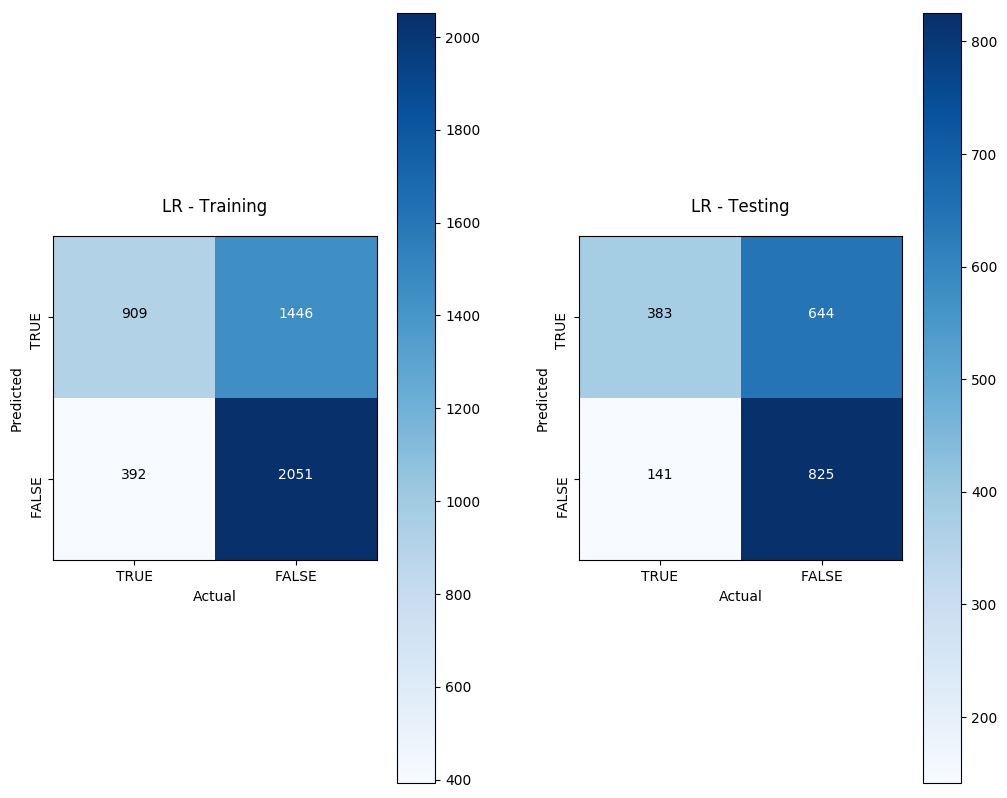

In [217]:
# Visualize the Confusion Matrix
conf_matrix_LR_Train = generate_cm(LR_train)
conf_matrix_LR_Test = generate_cm(LR_test)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
plot_cm(conf_matrix_LR_Train, "LR - Training", ax[0], fig)
plot_cm(conf_matrix_LR_Test, "LR - Testing", ax[1], fig)
plt.show()

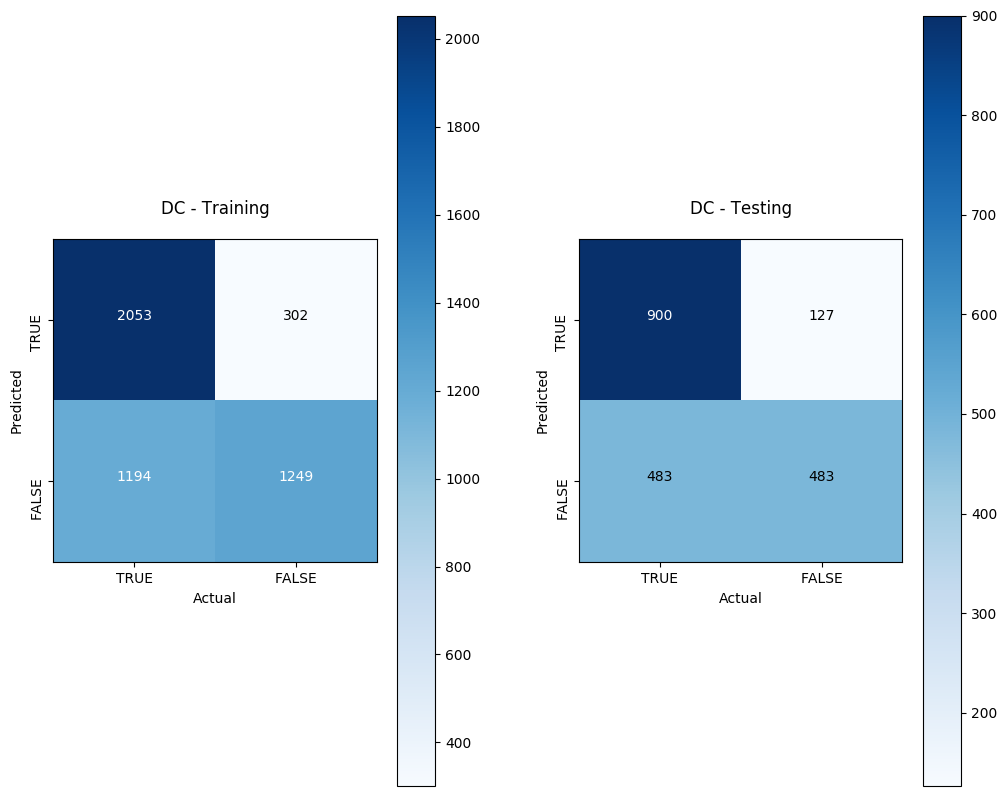

In [218]:
conf_matrix_DC_Train = generate_cm(DC_train)
conf_matrix_DC_Test = generate_cm(DC_test)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
plot_cm(conf_matrix_DC_Train, "DC - Training", ax[0], fig)
plot_cm(conf_matrix_DC_Test, "DC - Testing", ax[1], fig)
plt.show()

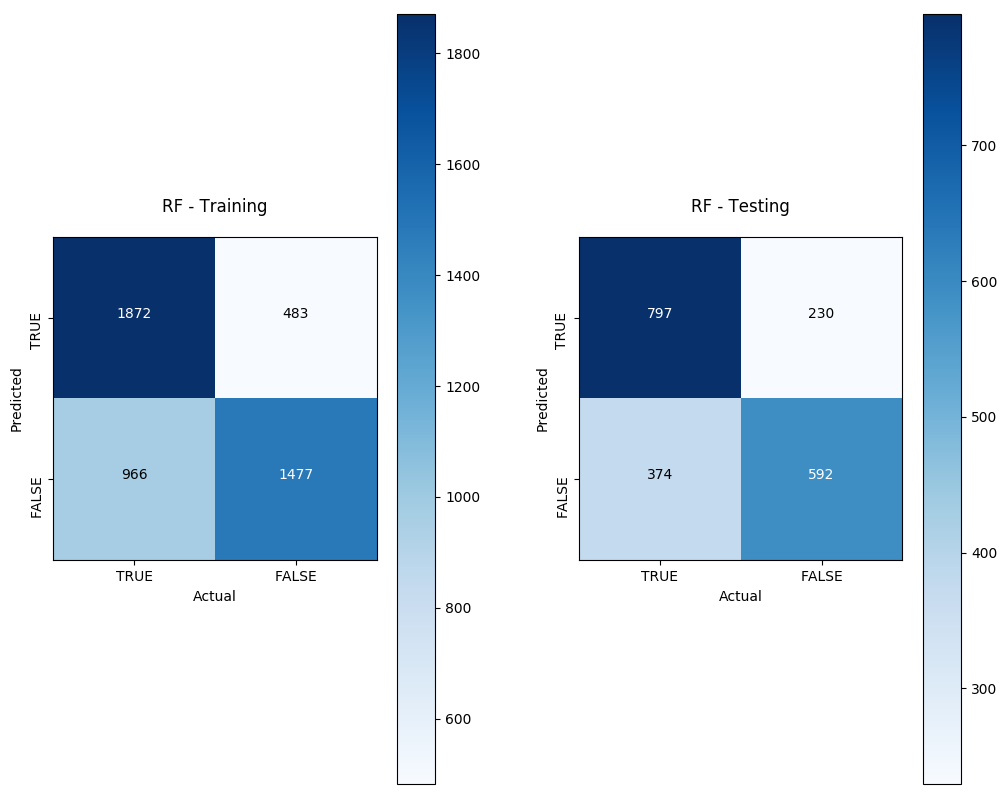

In [221]:
conf_matrix_RF_Train = generate_cm(RF_train)
conf_matrix_RF_Test = generate_cm(RF_test)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
plot_cm(conf_matrix_RF_Train, "RF - Training", ax[0], fig)
plot_cm(conf_matrix_RF_Test, "RF - Testing", ax[1], fig)
plt.show()

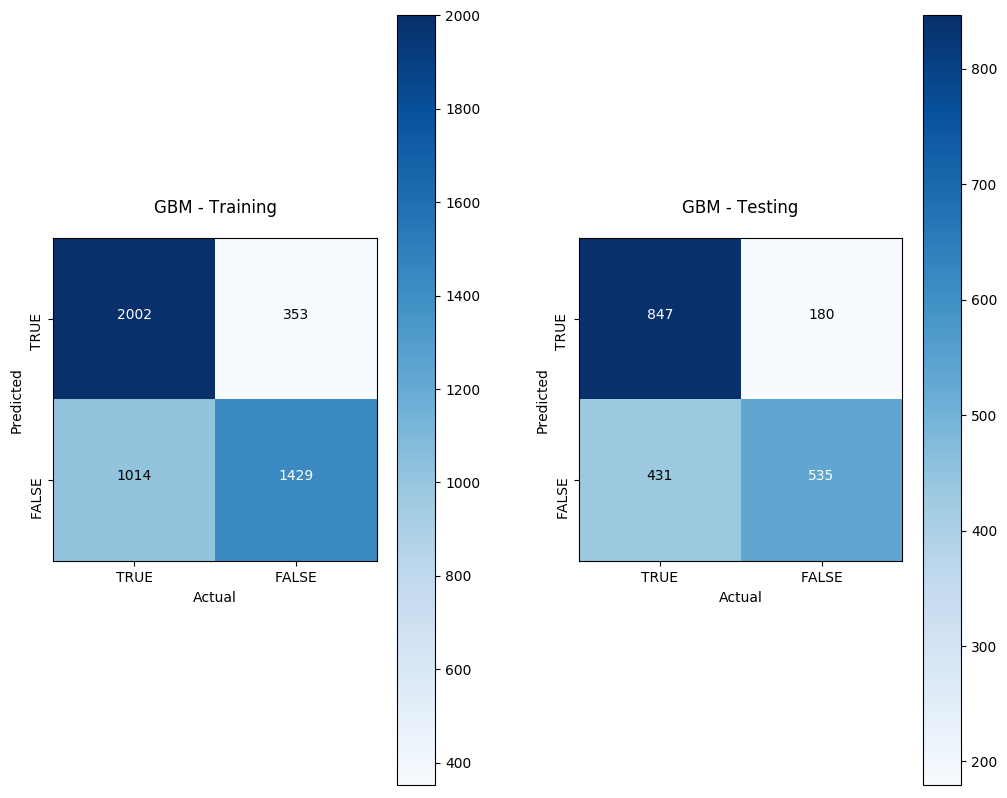

In [222]:
conf_matrix_GBM_Train = generate_cm(GBM_train)
conf_matrix_GBM_Test = generate_cm(GBM_test)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
plot_cm(conf_matrix_GBM_Train, "GBM - Training", ax[0], fig)
plot_cm(conf_matrix_GBM_Test, "GBM - Testing", ax[1], fig)
plt.show()

# Feature Importance from the Phase 1 (Random Forest)

In [207]:
# Extract the list of features from the one-hot encoded vector
features = train_data.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + train_data.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]

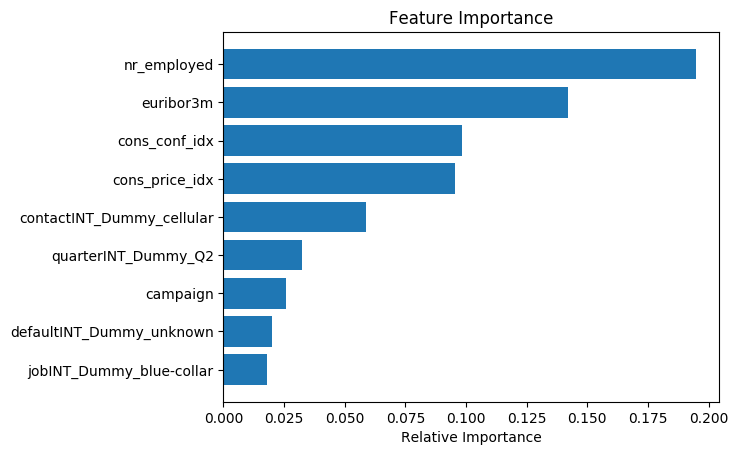

In [208]:
features_importance = pd.DataFrame([(f["name"], RF_model.featureImportances[f["idx"]]) 
                            for f in features], columns = ["feature", "importance"]).sort_values("importance", ascending = False)

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = features_importance['feature'][1:10]
y_pos = np.arange(len(people))
performance = features_importance['importance'][1:10]

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importance')

plt.show()

# Phase 2 - Model Hyperparameter Tuning

# Random Forest

In [224]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Build the Random Forest Hyperparameter Tuning Model
random_forest_tuning = RandomForestClassifier(featuresCol = "features", labelCol = "label").setSeed(1234)

# Specify the parameters
paramGrid = ParamGridBuilder().addGrid(random_forest_tuning.numTrees, [20,60,100,200])\
            .addGrid(random_forest_tuning.maxDepth, [5,8,10])\
            .addGrid(random_forest_tuning.maxBins, [16, 32]).build()
rf_crossval = CrossValidator(estimator=random_forest_tuning,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters.
RF_model_tuning = rf_crossval.fit(train_data)

# Apply the model to the training and testing data
RF_tuning_train = RF_model_tuning.transform(train_data)
RF_tuning_test = RF_model_tuning.transform(test_data)

# Evaluations - Accuracy and ROC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Evaluators
binary_eval = BinaryClassificationEvaluator(labelCol = "label")
multi_eval_acc = MulticlassClassificationEvaluator(labelCol = "label", metricName = "accuracy")

# Create pandas data frame to store the result of our model metrics
model_metrics = pd.DataFrame(columns = ["Dataset", "Accuracy", "ROC"])

# Random Forest
model_metrics = model_metrics.append(
    {
        "Dataset" : "Training",
        "Code" : "Random Forest",
        "Accuracy" : multi_eval_acc.evaluate(RF_tuning_train),
        "ROC" : binary_eval.evaluate(RF_tuning_train)
    },
    ignore_index = True
)

model_metrics = model_metrics.append(
    {
        "Dataset" : "Testing",
        "Code" : "Random Forest",
        "Accuracy" : multi_eval_acc.evaluate(RF_tuning_test),
        "ROC" : binary_eval.evaluate(RF_tuning_test)
    },
    ignore_index = True
)
    
model_metrics

# Confusion Matrix

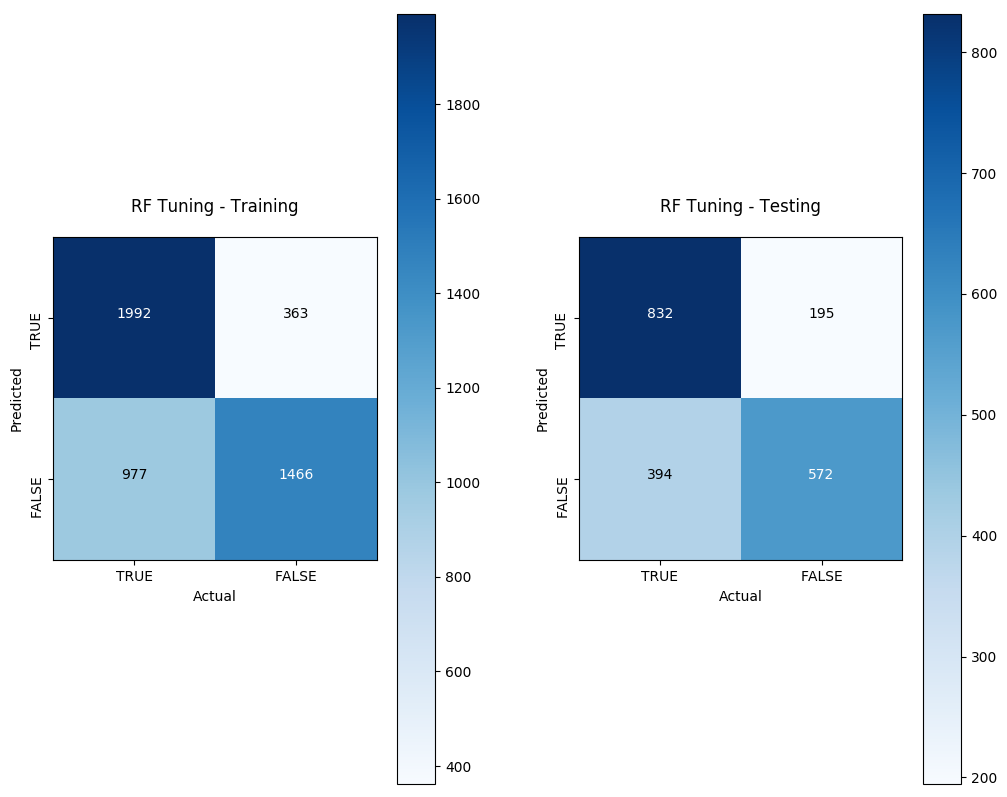

In [235]:
conf_matrix_RF_Tuning_Train = generate_cm(RF_tuning_train)
conf_matrix_RF_Tuning_Test = generate_cm(RF_tuning_test)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 10))
plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
plot_cm(conf_matrix_RF_Tuning_Train, "RF Tuning - Training", ax[0], fig)
plot_cm(conf_matrix_RF_Tuning_Test, "RF Tuning - Testing", ax[1], fig)
plt.show()

# Feature Importance from the Phase 2 (Random Forest)

In [236]:
# Extract the list of features from the one-hot encoded vector
features = train_data.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + train_data.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]

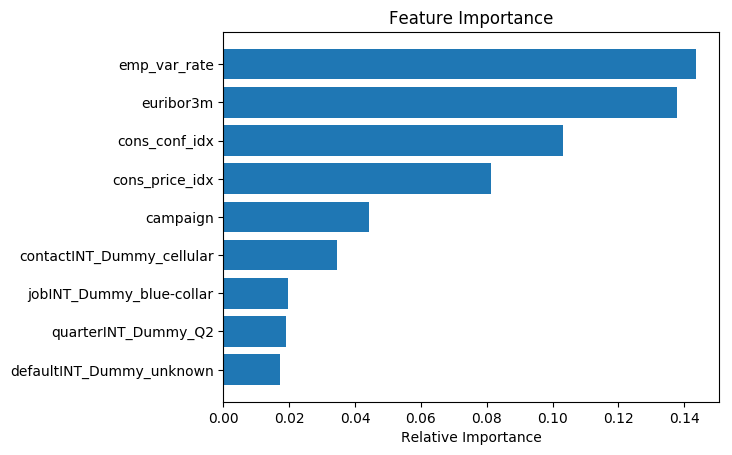

In [237]:
features_importance = pd.DataFrame([(f["name"], RF_model_tuning.bestModel.featureImportances[f["idx"]]) 
                            for f in features], columns = ["feature", "importance"]).sort_values("importance", ascending = False)

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = features_importance['feature'][1:10]
y_pos = np.arange(len(people))
performance = features_importance['importance'][1:10]

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Relative Importance')
ax.set_title('Feature Importance')

plt.show()